# Distributed Synchronous Value Iteration
***

The goal of this assignment is to implement both single-core and distributed versions of synchronous value iteration (VI). In particular, VI will be applied to Markov Decision Processes (MDPs) in order to compute policies that optimize expected infinite horizon discounted cummulative reward. 


### Synchronous Value Iteration Recap

Below is a review of the synchronous value iteration algorithm. The algorithm is iterative and each iteration produces a newly updated value function $V_{new}$ based on the value function from the previous iteration $V_{curr}$. This is done by applying the Bellman backup operator to $V_{curr}$ at each state. That is, 
\begin{equation}
V_{new}(s) = \max_{a\in A} R(s,a) + \beta \sum_{s'\in S} T(s,a,s') V_{curr}(s')
\end{equation}
where $\beta \in [0,1)$ is the discount factor, $R$ is the reward function, and $T$ is the transition function. 

The algorithm also maintains the greedy policy $\pi$ at each iteration, which is based on a one-step look ahead operator: 
\begin{equation}
\pi_{curr}(s) = \arg\max_{a\in A} R(s,a) + \beta \sum_{s'\in S} T(s,a,s') V_{curr}(s')
\end{equation}

After an update we define the Bellman error of that iteration as $\max_s |V_{new}(s)-V_{curr}(s)|$. In the notes, it is shown that this error allows us to bound the difference between the value function of $\pi_{curr}$ and the optimal value function $V^{*}$. Thus, a typical stopping condition for VI is to iterate until the Bellman error is below a specified threshold $\epsilon$. Putting everything together, the overall algorithm is as follows:

- Start with $V_{curr}(s) = 0$ for all $s$
- error = $\infty$
- While error > $\epsilon$ 
    - For each state $s$ 
        - $V_{new}(s) = \max_{a\in A} R(s,a) + \beta \sum_{s'\in S} T(s,a,s') V_{curr}(s')$
        - $\pi_{curr}(s) = \arg\max_{a\in A} R(s,a) + \beta \sum_{s'\in S} T(s,a,s') V_{curr}(s')$
    - error = $\max_s |V_{new}(s)-V_{curr}(s)|$   ;; could do this incrementally      
    - $V_{curr} = V_{new}$

The reason we refer to this version of VI as synchronous is because it maintains both a current and new value function, where all values of the new value function are computed based on the fixed current value function. That is, each iteration updates all states based on the value function of the previous iteration. 

To simplify this first assignment, we have decided to focus on Synchronous VI and to investigate how to best create a distributed implementation using the Ray framework. In particular, a distributed version of Synchronous VI should still produce a sequence of value functions and policies that are equivalent to those that would be produced by a single-core version, but ideally do so much faster. The remainder of this notebook guides you through some of the MDP mechanics and algorithm implementations. The grand finale of this first assignment is a competition where you will try to develop the fasted distributed implementation that you can. 

In [1]:
# You will need to uncomment the following pip commands if the libraries need to be installed. 
# You may get some errors related to readchar, but they should not break the project.

#!pip install --user readchar
#!pip install --user gym

In [2]:
import ray
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from random import randint, choice
%matplotlib inline
import pickle

***

## FrozenLake

We will use the FrozenLake environment as the MDP environment for this experiment. This is a type of gridworld environment, whose size (number of states) can be controlled by adjusting the grid dimensions. The environment is intended to model the process of navigating a frozen lake, while avoiding falling into holes with the objective of reaching a goal location. 

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are four different types of cells as indicated by the following cell labels: 

    - S labels the starting/initial cell, always in the top left corner
    
    - F labels frozen cells that are safe to step on

    - H labels holes and if the agent enters a hole cell there is a pentalty of -1000 and the episode ends

    - G labels the goal cell and when reached gives a reward of 1000 and the episode ends

- There are four possible actions (Left, Right, Down, Up). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the other randomly selected directions. 

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. 

- Episodes end whenever the agent falls in a hole or reaches the goal. An end-of-episode is modeled by transitioning to a zero-reward terminal state (all actions lead to that state). 
   
Below is the code for the FrozenLake environment class, which has the following functions that will be used in this assignment: 

- FrozenLake.GetSuccesors() : Take a state and an action as input, and return a list of pairs, where each pair $(s',p)$ is a successor state $s'$ with non-zero probability and $p$ is the probability of transitioning to $p$.  

- FrozenLake.GetTransitionProb() : Take a state, an action, a next state as input, and return the probability of the transition 

- FrozenLake.GetReward() : Take a state and an action as input, and return the reward of that.

The version we are using for the assignment 2 is a modified version of the environment at the following location.   
  
Source: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py  

Execute the following cell to initialize the MDP environments. (You do not need to change the code in this part.)

In [3]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize, precision = 2)
TransitionProb = [0.7, 0.1, 0.1, 0.1]
def generate_row(length, h_prob):
    row = np.random.choice(2, length, p=[1.0 - h_prob, h_prob])
    row = ''.join(list(map(lambda z: 'F' if z == 0 else 'H', row)))
    return row


def generate_map(shape):
    """

    :param shape: Width x Height
    :return: List of text based map
    """
    h_prob = 0.1
    grid_map = []

    for h in range(shape[1]):

        if h == 0:
            row = 'SF'
            row += generate_row(shape[0] - 2, h_prob)
        elif h == 1:
            row = 'FF'
            row += generate_row(shape[0] - 2, h_prob)

        elif h == shape[1] - 1:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FG'
        elif h == shape[1] - 2:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FF'
        else:
            row = generate_row(shape[0], h_prob)

        grid_map.append(row)
        del row

    return grid_map



MAPS = {
    
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "16x16": [
        "SFFFFFFFFHFFFFHF",
        "FFFFFFFFFFFFFHFF",
        "FFFHFFFFHFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFFFFFFFF",
        "FFHHFFFFFFFHFFFH",
        "FFFFFFFFFFFFFFFF",
        "FFFFFHFFFFFFHFFF",
        "FFFFFHFFFFFFFFFH",
        "FFFFFFFHFFFFFFFF",
        "FFFFFFFFFFFFHFFF",
        "FFFFFFHFFFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFHFFFFHF",
        "FFFFFFFFFFHFFFFF",
        "FFFHFFFFFFFFFFFG",
    ],
    
    "32x32": [
        'SFFHFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFHFHHFFHFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH',
        'FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF',
        'FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF',
        'FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF',
        'FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH',
        'FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF',
        'FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH',
        'FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF',
        'FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF',
        'FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF',
        'FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF',
        'FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF',
        'FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH',
        'FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF',
        'FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH',
        'FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF',
        'FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF',
        'FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFFFFFHFFFFFFG',
    ]
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # BFS to check that it's a valid path.
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True

        tmp = arr[r][c]
        arr[r][c] = "#"

        # Recursively check in all four directions.
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        for x, y in directions:
            r_new = r + x
            c_new = c + y
            if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                continue

            if arr[r_new][c_new] not in '#H':
                if is_valid(arr, r_new, c_new):
                    arr[r][c] = tmp
                    return True

        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        rew_hole = -1000
        rew_goal = 1000
        rew_step = -1
        
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        self.TransitProb = np.zeros((nA, nS + 1, nS + 1))
        self.TransitReward = np.zeros((nS + 1, nA))
        
        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'H':
                        li.append((1.0, s, 0, True))
                        self.TransitProb[a, s, nS] = 1.0
                        self.TransitReward[s, a] = rew_hole
                    elif letter in b'G':
                        li.append((1.0, s, 0, True))
                        self.TransitProb[a, s, nS] = 1.0
                        self.TransitReward[s, a] = rew_goal
                    else:
                        if is_slippery:
                            #for b in [(a-1)%4, a, (a+1)%4]:
                            for b, p in zip([a, (a+1)%4, (a+2)%4, (a+3)%4], TransitionProb):
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                #rew = float(newletter == b'G')
                                #li.append((1.0/10.0, newstate, rew, done))
                                if newletter == b'G':
                                    rew = rew_goal
                                elif newletter == b'H':
                                    rew = rew_hole
                                else:
                                    rew = rew_step
                                li.append((p, newstate, rew, done))
                                self.TransitProb[a, s, newstate] += p
                                self.TransitReward[s, a] = rew_step
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
    
    def GetSuccessors(self, s, a):
        next_states = np.nonzero(self.TransitProb[a, s, :])
        probs = self.TransitProb[a, s, next_states]
        return [(s,p) for s,p in zip(next_states[0], probs[0])]
    
    def GetTransitionProb(self, s, a, ns):
        return self.TransitProb[a, s, ns]
    
    def GetReward(self, s, a):
        return self.TransitReward[s, a]
    
    def GetStateSpace(self):
        return self.TransitProb.shape[1]
    
    def GetActionSpace(self):
        return self.TransitProb.shape[0]

## Play Game
Have Fun!  
(You don't have to do this part, but if you do make sure to use quite using "q" so that you can continue.)

In [4]:
print("---------actions--------")
print("a: Left\ns: Down\nd: Right\nw: Up\n(q: quit)")
env = FrozenLakeEnv(map_name="16x16")
env.render()
rew = 0
for _ in range(1000):
    a = input("input action: ")
    if a == 'a':
        a = 0
    elif a == 's':
        a = 1
    elif a == 'd':
        a = 2
    elif a == 'w':
        a = 3
    elif a == 'q':
        break
    else:
        print('illegal input')
        continue
    observation, reward, done, info = env.step(a)
    rew += reward
    print(chr(27) + "[2J")
    print("---------actions--------")
    print("a: Left\ns: Down\nd: Right\nw: Up\n(q: quit)")
    print()
    print("current state:" + str(observation))
    if info['prob'] == TransitionProb[0] or info['prob'] == 1:
        print('move to expected direstion')
    else:
        print('move to unexpected direstion')
    print("probabilty: " + str(info['prob']))
    print("current reward:" + str(rew))
    print()
    env.render()
    print()
    if done:
        print('end')
        break
   

---------actions--------
a: Left
s: Down
d: Right
w: Up
(q: quit)

SFFFFFFFFHFFFFHF
FFFFFFFFFFFFFHFF
FFFHFFFFHFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFF
FFHHFFFFFFFHFFFH
FFFFFFFFFFFFFFFF
FFFFFHFFFFFFHFFF
FFFFFHFFFFFFFFFH
FFFFFFFHFFFFFFFF
FFFFFFFFFFFFHFFF
FFFFFFHFFFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFHFFFFHF
FFFFFFFFFFHFFFFF
FFFHFFFFFFFFFFFG


input action:  Q


illegal input


input action:  q


***
***
## Initializations

Run the following cell to initilize maps of different sizes.

In [5]:
map_8 = (MAPS["8x8"], 8)
map_16 = (MAPS["16x16"], 16)
map_32 = (MAPS["32x32"], 32)
#map_50 = (generate_map((50,50)), 50)
#map_110 = (generate_map((110,110)), 110)

MAP = map_8
map_size = MAP[1]
run_time = {}

## Empirical Policy Evaluation 

As a warm up we are going to get experience running a policy in an MDP to empirically evaluate the performance of the policy. 

Run the following cell to define the policy evaluation function, which allows us to run a specified policy in a specified environment for a specified number of trials. The function assumes that the trials will terminate for any policy, which is indicated by the "done" variable returned by the environment. This version of the function measures performance by total cummulative reward. Since the environment is stochastic each trial may return a different total reward. This function returns the average cummulative reward across the trials. 


In [6]:
def evaluate_policy(env, policy, trials = 1000):
    total_reward = 0
    for _ in range(trials):
        env.reset()
        done = False
        observation, reward, done, info = env.step(policy[0])
        total_reward += reward
        while not done:
            observation, reward, done, info = env.step(policy[observation])
            total_reward += reward
    return total_reward / trials

## Discounted Policy Evaluation 
Create a modified version of the above evaluation function that measure the discounted total reward rather than just the total reward as above. The discount factor is specified via a parameter to the function. Specifically, if a trial results in a sequence of rewards: $r_0, r_1, r_2, r_3$ the discounted total reward would be $r_0 + \beta r_1 + \beta^2 r_2 + \beta^3 r_3$, where $\beta$ is the discount factor.  


In [7]:
def evaluate_policy_discounted(env, policy, discount_factor, trials = 1000):
    total_reward = 0
    
    #INSERT YOUR CODE HERE
    for _ in range(trials):
        env.reset()
        done = False
        observation, reward, done, info = env.step(policy[0])
        total_reward += reward
        beta = 1
        while not done:
            beta *= discount_factor
            observation, reward, done, info = env.step(policy[observation])
            total_reward +=  beta * reward
    return total_reward / trials

## Helper Function
Execute the following cell to define the print function. This function shows the policy and state values and saves them to disk. We will use this later in the assignment.

In [8]:
def print_results(v, pi, map_size, env, beta, name):
    v_np, pi_np  = np.array(v), np.array(pi)
    print("\nState Value:\n")
    print(np.array(v_np[:-1]).reshape((map_size,map_size)))
    print("\nPolicy:\n")
    print(np.array(pi_np[:-1]).reshape((map_size,map_size)))
    print("\nAverage reward: {}\n".format(evaluate_policy(env, pi)))
    print("Avereage discounted reward: {}\n".format(evaluate_policy_discounted(env, pi, discount_factor = beta)))
    print("State Value image view:\n")
    plt.imshow(np.array(v_np[:-1]).reshape((map_size,map_size)))
    
    pickle.dump(v, open(name + "_" + str(map_size) + "_v.pkl", "wb"))
    pickle.dump(pi, open(name + "_" + str(map_size) + "_pi.pkl", "wb"))

## Random policy  
To provide a reference point for policy performance the following cell defines a random policy (selects actions uniformly at random) and evaluates it. Execute the cell and observe the results. 

In [9]:
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
env.render()
pi = [0] * map_size * map_size
for i in range(map_size * map_size):
    pi[i] = randint(0, 3)
print("Average reward:", evaluate_policy(env, pi))
print("Average discounted reward:", 
      evaluate_policy_discounted(env, pi, discount_factor = 0.999))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Average reward: -1063.804
Average discounted reward: -1000.0000000001127


***
## Synchronous Value Iteration with full transition function

In this section, you should implement the synchronous value iteration algorithm. A code skeleton is provided below. Complete the given code by implementing the Bellman backup operator. Recall that the Bellman backup for a state assuming the current value function is $V$ is given by:
\begin{equation}
V_{new}(s) = \max_{a\in A} R(s,a) + \beta \sum_{s'\in S} T(s,a,s') V(s')
\end{equation}

For this part of the assignment you should implement this Bellman backup operator in a way that performs the sum over all possible next states $s' \in S$. You will want to use the functions env.GetTransitionProb() to get the transition probabilities and env.GetReward() to get the rewards. In each iteration you need to do the following:

1. Apply the Bellman backup to all state. 
2. Compute and update the Bellman error (see first part of document).
3. Update the value and policy accordingly.

In [10]:
def sync_value_iteration_v1(env, beta = 0.999, epsilon = 0.0001):
    
    A = env.GetActionSpace()
    S = env.GetStateSpace()
    
    pi = [0] * S
    v = [0] * S
    
    pi_new = [0] * S
    v_new = [0] * S
    
    bellman_error = float('inf')
    while(bellman_error > epsilon):
        for state in range(S):
            max_v = float('-inf')
            max_a = 0
            for action in range(A):
                #INSERT YOUR CODE HERE
                beta_term = 0
                for observation in range(S):
                    beta_term += env.GetTransitionProb(state, action, observation) * v[observation]
                bellman_v = env.GetReward(state, action) + beta * beta_term
                if bellman_v > max_v:
                    max_v = bellman_v
                    max_a = action
            v_new[state] = max_v
            pi_new[state] = max_a
        bellman_error = max([abs(v_new[k] - v[k]) for k in range(len(v))])
        v = deepcopy(v_new)
        pi = deepcopy(pi_new)
        
    return v, pi

Run the following cell to see the output of your function and store the value and policy matrices to file.

Game Map:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
time: 0.905534029006958

State Value:

[[  363.5    365.91   369.38   376.73   400.45   411.84   418.7    422.15]
 [  360.24   357.72   335.12   231.84   358.44   389.37   415.63   424.67]
 [  353.55   333.99   189.29 -1000.     173.63   227.87   389.72   428.36]
 [  339.83   306.42   225.01   -42.34    11.12 -1000.     269.05   436.45]
 [  290.6    139.46   -29.52 -1000.     -51.75    81.41   258.29   463.58]
 [  110.07 -1000.   -1000.    -309.32   -88.99    68.62 -1000.     498.87]
 [  -32.47 -1000.    -463.4   -463.4  -1000.     243.49 -1000.     720.18]
 [  -53.06  -187.65  -309.32 -1000.     262.9    625.53   734.24  1000.  ]]

Policy:

[[2 2 2 2 2 2 2 1]
 [3 3 3 3 3 2 2 1]
 [3 3 3 0 3 2 2 1]
 [3 0 0 0 3 0 2 1]
 [3 3 3 0 2 2 2 1]
 [3 0 0 2 2 1 0 1]
 [3 0 1 3 0 1 0 1]
 [3 0 0 0 2 2 2 0]]

Average reward: 335.673

Avereage discounted reward: 376.1127260914477

State Value image view:



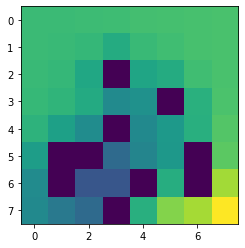

In [11]:
#MAP_8
beta = 0.999
MAP = map_8
map_size = 8
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_v1(env, beta = beta)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync Value Iteration v1'] = end_time - start_time
print("time:", run_time['Sync Value Iteration v1'])

print_results(v, pi, map_size, env, beta, 'sync_vi')

Game Map:

SFFFFFFFFHFFFFHF
FFFFFFFFFFFFFHFF
FFFHFFFFHFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFF
FFHHFFFFFFFHFFFH
FFFFFFFFFFFFFFFF
FFFFFHFFFFFFHFFF
FFFFFHFFFFFFFFFH
FFFFFFFHFFFFFFFF
FFFFFFFFFFFFHFFF
FFFFFFHFFFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFHFFFFHF
FFFFFFFFFFHFFFFF
FFFHFFFFFFFFFFFG
time: 19.822930812835693

State Value:

[[  457.2    459.73   463.34   470.97   495.86   504.93   499.93   469.89   283.22 -1000.     236.6    379.77   325.97    30.16 -1000.     131.65]
 [  454.02   451.66   428.15   319.12   472.18   509.1    505.65   460.98   272.61   228.76   394.57   409.88   258.44 -1000.      66.26   294.93]
 [  448.71   430.88   281.65 -1000.     357.93   517.61   514.51   342.37 -1000.     265.33   440.63   440.02   401.89   258.59   339.76   352.78]
 [  443.88   431.07   385.1    316.27   497.41   544.26   542.09   374.62 -1000.     352.77   474.41   451.74   435.81   408.12   390.49   364.84]
 [  437.32   401.86   249.45   308.85   505.13   557.27   571.85   553.64   425.54   543.

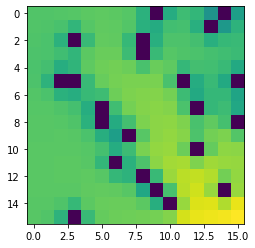

In [12]:
#MAP_16
beta = 0.999
MAP = map_16
map_size = 16
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_v1(env, beta = beta)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync Value Iteration v1'] = end_time - start_time
print("time:", run_time['Sync Value Iteration v1'])

print_results(v, pi, map_size, env, beta, 'sync_vi')

Game Map:

SFFHFFFFFFFFFFFFFFFFFFFFFFHFFFFF
FFHFHHFFHFFFFFFFFFFFFFFFFFHFFFFF
FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH
FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF
FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF
FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF
FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF
FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH
FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF
FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH
FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF
FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF
FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF
FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF
FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF
FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF
FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH
FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF
FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF
FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH
FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF
FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF
FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF
FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF

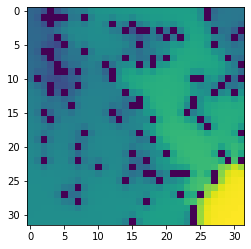

In [13]:
#MAP_32
beta = 0.999
MAP = map_32
map_size = 32
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_v1(env, beta = beta)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync Value Iteration v1'] = end_time - start_time
print("time:", run_time['Sync Value Iteration v1'])

print_results(v, pi, map_size, env, beta, 'sync_vi')

## Synchronous Value Iteration Using GetSuccessors()
The above version of value iteration can be very innefficient when the number of states is large because it iterates over all next states. In practice, it is usually the case that for any state $s$ and action $a$ most states have zero probability of being successors. We can exploit that fact to make value iteration more efficient. 

The goal of this part is to use GetSuccessors() function to decrease the running time. This function takes a state and an action as input and returns the possible next states (with non-zero transition probability) and their transition probabilities. this allows us to ignore all states with zero transition probability. Implement value iteration in the following cell following the previous implmentation. But, here, use the env.GetSuccessors() function ot limit the Bellman backup to only consider non-zero probability states in the summation over next states. Using this function you will not need the GetTransitionProb function.


In [14]:
def sync_value_iteration_v2(env, beta = 0.999, epsilon = 0.0001):
    
    A = env.GetActionSpace()
    S = env.GetStateSpace()
    
    pi = [0] * S
    v = [0] * S
    
    pi_new = [0] * S
    v_new = [0] * S
    
    error = float('inf')
    
    #INSERT YOUR CODE HERE
    bellman_error = float('inf')
    while bellman_error > epsilon:
        for state in range(S):
            max_v = float('-inf')
            max_a = 0
            for action in range(A):
                beta_term = 0
                s_p_pairs = env.GetSuccessors(state, action)
                for (observation, transition_prob) in s_p_pairs:
                    beta_term += transition_prob * v[observation]
                bellman_v = env.GetReward(state, action) + beta_term * beta
                if bellman_v > max_v:
                    max_v = bellman_v
                    max_a = action
            v_new[state] = max_v
            pi_new[state] = max_a
        bellman_error = max([abs(v_new[k] - v[k]) for k in range(len(v))])
        v = deepcopy(v_new)
        pi = deepcopy(pi_new)
        
    return v, pi

Run the following cell to see the output of your function and store the value and policy matrices to file. Note the time taken for this version versus the previous version of value iteration. The computation time should be significantly smaller for this later version that uses GetSuccessors. Because of this time savings, for the remainder of this assignment you should implement Bellman backups using GetSuccessors. 

Game Map:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
time: 0.3082435131072998

State Value:

[[  363.5    365.91   369.38   376.73   400.45   411.84   418.7    422.15]
 [  360.24   357.72   335.12   231.84   358.44   389.37   415.63   424.67]
 [  353.55   333.99   189.29 -1000.     173.63   227.87   389.72   428.36]
 [  339.83   306.42   225.01   -42.34    11.12 -1000.     269.05   436.45]
 [  290.6    139.46   -29.52 -1000.     -51.75    81.41   258.29   463.58]
 [  110.07 -1000.   -1000.    -309.32   -88.99    68.62 -1000.     498.87]
 [  -32.47 -1000.    -463.4   -463.4  -1000.     243.49 -1000.     720.18]
 [  -53.06  -187.65  -309.32 -1000.     262.9    625.53   734.24  1000.  ]]

Policy:

[[2 2 2 2 2 2 2 1]
 [3 3 3 3 3 2 2 1]
 [3 3 3 0 3 2 2 1]
 [3 0 0 0 3 0 2 1]
 [3 3 3 0 2 2 2 1]
 [3 0 0 2 2 1 0 1]
 [3 0 1 3 0 1 0 1]
 [3 0 0 0 2 2 2 0]]

Average reward: 397.693

Avereage discounted reward: 331.11642964838546

State Value image view:



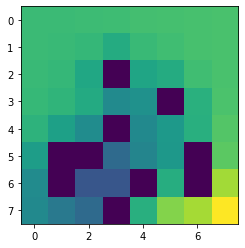

In [15]:
beta = 0.999
MAP = map_8
map_size = 8
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_v2(env, beta = beta)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync Value Iteration v2'] = end_time - start_time
print("time:", run_time['Sync Value Iteration v2'])

print_results(v, pi, map_size, env, beta, 'sync_vi_gs')

Game Map:

SFFFFFFFFHFFFFHF
FFFFFFFFFFFFFHFF
FFFHFFFFHFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFF
FFHHFFFFFFFHFFFH
FFFFFFFFFFFFFFFF
FFFFFHFFFFFFHFFF
FFFFFHFFFFFFFFFH
FFFFFFFHFFFFFFFF
FFFFFFFFFFFFHFFF
FFFFFFHFFFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFHFFFFHF
FFFFFFFFFFHFFFFF
FFFHFFFFFFFFFFFG
time: 1.6488120555877686

State Value:

[[  457.2    459.73   463.34   470.97   495.86   504.93   499.93   469.89   283.22 -1000.     236.6    379.77   325.97    30.16 -1000.     131.65]
 [  454.02   451.66   428.15   319.12   472.18   509.1    505.65   460.98   272.61   228.76   394.57   409.88   258.44 -1000.      66.26   294.93]
 [  448.71   430.88   281.65 -1000.     357.93   517.61   514.51   342.37 -1000.     265.33   440.63   440.02   401.89   258.59   339.76   352.78]
 [  443.88   431.07   385.1    316.27   497.41   544.26   542.09   374.62 -1000.     352.77   474.41   451.74   435.81   408.12   390.49   364.84]
 [  437.32   401.86   249.45   308.85   505.13   557.27   571.85   553.64   425.54   543.

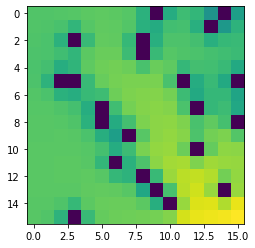

In [16]:
beta = 0.999
MAP = map_16
map_size = 16
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_v2(env, beta = beta)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync Value Iteration v2'] = end_time - start_time
print("time:", run_time['Sync Value Iteration v2'])

print_results(v, pi, map_size, env, beta, 'sync_vi_gs')

Game Map:

SFFHFFFFFFFFFFFFFFFFFFFFFFHFFFFF
FFHFHHFFHFFFFFFFFFFFFFFFFFHFFFFF
FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH
FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF
FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF
FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF
FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF
FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH
FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF
FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH
FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF
FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF
FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF
FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF
FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF
FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF
FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH
FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF
FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF
FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH
FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF
FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF
FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF
FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF

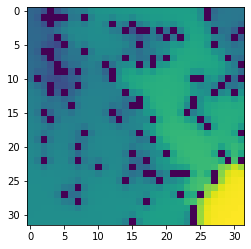

In [17]:
beta = 0.999
MAP = map_32
map_size = 32
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_v2(env, beta = beta)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync Value Iteration v2'] = end_time - start_time
print("time:", run_time['Sync Value Iteration v2'])

print_results(v, pi, map_size, env, beta, 'sync_vi_gs')

***
## Initialize Ray

Now we are going to use Ray to develop distributed versions of the above value iteration algorithm. The first step of course is to initialize Ray.

In [18]:
#ray.shutdown()
#ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=500000000, object_store_memory=5000000000)

## Distributed Synchronous Value Iteration -- Version 1
A simple way to distribute Value Iteration would be to implement each iteration by having a each state updated by a distinct worker. That is each state is updated by creating a work to do the Bellman backup for that state and then recording the result. In order to avoid creating an enormous number of workers, the first implementation will only allow a specified number of workers to be active at any time. After each iteration, the main process checks the Bellman error and if it is less than the specified epsilon it terminates. The following diagram demonstrates the architecture of such a system.


```python

"""

                                +---------------+
                                |               |
                                | Main Process  |------------------------------------
                                |               |                                   |
                                |               |                                   |
                                +---------------+                                   |
                                        |                                           |
                                        |                                           |
                                        |                                           |
                                        |                                           |
                                        |                                           |
     +---Re-init Worker-----+-------------------+-----Re-init Worker---+          Check
     |                      |                   |                      |        Coverage
+-----------+         +-----------+       +-----------+         +-----------+  Iteratively
|           |         |           |       |           |         |           |       |
|  Worker   |         |  Worker   |       |  Worker   |         |  Worker   |       |
|  (env)    |         |  (env)    |       |  (env)    |         |  (env)    |       |        
|           |         |           |       |           |         |           |       |
+-----------+         +-----------+       +-----------+         +-----------+       |
      ^                     ^                   ^                     ^             |
      |                     |                   |                     |             |
      +------ One-Value ----+---------+---------+----- One-Value -----+             |
                                      |                                             |
                                      |                                             |
                              +----------------+                                    |             
                              |                |                                    |                   
                              |  Value Server  |-------------------------------------                        
                              |                |                  
                              +----------------+

"""

```

A key part of this implementation is the Value Server, which is a Ray actor that workers interface with to update the value function at each iteration. In order to avoid 

You need to complete the following code by adding the Bellman backup operator to it. Once you implemented the function, run the following cell to test it and to store the value and policy matrices to file. Note that this implementation should replicate the results of the non-distributed version of synchronous value iteration. 

Importantly you should see that this version is significantly slower than the above non-distributed version. Think about why this might be the case. 

In [11]:
@ray.remote
class VI_server_v1(object):
    def __init__(self,size):
        self.v_current = [0] * size
        self.pi = [0] * size
        self.v_new = [0] * size
        
    def get_value_and_policy(self):
        return self.v_current, self.pi
    
    def update(self, update_index, update_v, update_pi):
        self.v_new[update_index] = update_v
        self.pi[update_index] = update_pi
    
    def get_error_and_update(self):
        max_error = 0
        for i in range(len(self.v_current)):
            error = abs(self.v_new[i] - self.v_current[i])
            if error > max_error:
                max_error = error
            self.v_current[i] = self.v_new[i]
            
        return max_error
    
@ray.remote
def VI_worker_v1(VI_server, data, worker_id, update_state):
        env, workers_num, beta, epsilon = data
        A = env.GetActionSpace()
        S = env.GetStateSpace()
            
        # get shared variable      
        V, _ = ray.get(VI_server.get_value_and_policy.remote())
        
        # bellman backup
        
        #INSERT YOUR CODE HERE
        max_v = float('-inf')
        max_a = 0
        for action in range(A):
            successors = env.GetSuccessors(update_state, action)
            beta_term = 0
            for observation, transition_prob in successors:
                beta_term += transition_prob * V[observation]

            bellman_v = env.GetReward(update_state, action) + beta * beta_term
            if bellman_v > max_v:
                max_v = bellman_v
                max_a = action
        
        VI_server.update.remote(update_state, max_v, max_a)
        
        # return ith worker
        return worker_id
                    
def sync_value_iteration_distributed_v1(env, beta = 0.999, epsilon = 0.01, workers_num = 4, stop_steps = 2000):
    S = env.GetStateSpace()
    VI_server = VI_server_v1.remote(S)
    workers_list = []
    data_id = ray.put((env, workers_num, beta, epsilon))
    
    start = 0
    # start the all worker, store their id in a list
    for i in range(workers_num):
        w_id = VI_worker_v1.remote(VI_server, data_id, i, start)
        workers_list.append(w_id)
        start += 1
    
    error = float('inf')
    while error > epsilon:
        for update_state in range(start, S):
            # Wait for one worker finishing, get its reuslt, and delete it from list
            finished_worker_id = ray.wait(workers_list, num_returns = 1, timeout = None)[0][0]
            finish_worker = ray.get(finished_worker_id)
            workers_list.remove(finished_worker_id)

            # start a new worker, and add it to the list
            w_id = VI_worker_v1.remote(VI_server, data_id, finish_worker, update_state)
            workers_list.append(w_id)
        start = 0
        error = ray.get(VI_server.get_error_and_update.remote())

    v, pi = ray.get(VI_server.get_value_and_policy.remote())
    return v, pi

2020-07-05 17:53:57,620	INFO resource_spec.py:212 -- Starting Ray with 181.4 GiB memory available for workers and up to 4.66 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Game Map:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
(pid=9367) E0705 17:54:11.159499  9367 direct_actor_transport.h:294] client skipping requests 1 to 1
(pid=9367) E0705 17:54:11.587028  9367 direct_actor_transport.h:338] Cancelling stale RPC with seqno 1 < 2
(pid=9367) E0705 17:54:11.593094  9367 direct_actor_transport.h:294] client skipping requests 1 to 1
(pid=9367) E0705 17:54:11.593144  9367 direct_actor_transport.h:338] Cancelling stale RPC with seqno 1 < 2
(pid=9367) E0705 17:54:11.593613  9367 direct_actor_transport.h:294] client skipping requests 1 to 1
(pid=9367) E0705 17:54:11.593643  9367 direct_actor_transport.h:338] Cancelling stale RPC with seqno 1 < 2
(pid=9378) E0705 17:54:11.594722  9524 task_manager.cc:254] Task failed: IOError: 2: client cancelled stale rpc: Type=ACTOR_TASK, Language=PYTHON, function_descriptor={type=PythonFunctionDescriptor, module_name=__main__, class_name=VI_server_v1, function_name=update, function_hash=}, task_id=

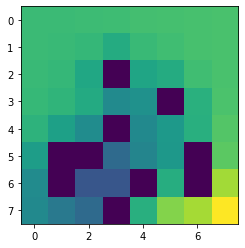

In [20]:
ray.shutdown()
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=500000000, object_store_memory=5000000000)
beta = 0.999
MAP = map_8
map_size = 8
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed_v1(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed v1'] = end_time - start_time
print("time:", run_time['Sync distributed v1'])

print_results(v, pi, map_size, env, beta, 'dist_vi_v1')
ray.shutdown()

In [ ]:
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=1000000000, object_store_memory=10000000000)
beta = 0.999
MAP = map_16
map_size = 16
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed_v1(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed v1'] = end_time - start_time
print("time:", run_time['Sync distributed v1'])

print_results(v, pi, map_size, env, beta, 'dist_vi_v1')
ray.shutdown()

In [ ]:
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=1000000000, object_store_memory=10000000000)
beta = 0.999
MAP = map_32
map_size = 32
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed_v1(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed v1'] = end_time - start_time
print("time:", run_time['Sync distributed v1'])

print_results(v, pi, map_size, env, beta, 'dist_vi_v1')
ray.shutdown()

## Distributed Synchronous Value Iteration -- Version 2

One way to improve the above approach is to create a limited number of workers and have each worker perform backups on a batch of states. Effectively, this approach partitions the state space and uses a worker to handle each state subset of the partition. The following diagram demonstrates the architecture of such a system.


```python

"""

                                +---------------+
                                |               |
                                | Main Process  |------------------------------------
                                |               |                                   |
                                |               |                                   |
                                +---------------+                                   |
                                        |                                           |
                                        |                                           |
                                        |                                           |
                                        |                                           |
                                        |                                           |
     +---Re-init Worker-----+-------------------+-----Re-init Worker---+          Check
     |                      |                   |                      |        Coverage
+-----------+         +-----------+       +-----------+         +-----------+  Iteratively
|           |         |           |       |           |         |           |       |
|  Worker   |         |  Worker   |       |  Worker   |         |  Worker   |       |
|  (env)    |         |  (env)    |       |  (env)    |         |  (env)    |       |        
|           |         |           |       |           |         |           |       |
+-----------+         +-----------+       +-----------+         +-----------+       |
      ^                     ^                   ^                     ^             |
      |                     |                   |                     |             |
      +---- Batch-Value ----+---------+---------+---- Batch-Value ----+             |
                                      |                                             |
                                      |                                             |
                              +----------------+                                    |             
                              |                |                                    |                   
                              |  Value Server  |-------------------------------------                        
                              |                |                  
                              +----------------+

"""

```
In this section, you should implement the idea described above.
- Partition the states into batches. The number of batches should be equal to the number of the workers.
- Create workers to handle each batch and run them
- Terminate the workers once the error is less than the given epsilon

Again, this implementation should exactly emulate the result of each iteration of non-distributed value iteration. 

In [10]:
@ray.remote
class VI_server_v2(object):
    # INSERT YOUR CODE HERE
    def __init__(self, size):
        self.v_current = [0] * size
        self.v_new = [0] * size
        self.pi = [0] * size

    def get_value_and_policy(self):
        return self.v_current, self.pi

    def update(self, start_state, end_state, batch_v, batch_a):
        self.v_new[start_state: end_state] = batch_v
        self.pi[start_state: end_state] = batch_a

    def get_error_and_update(self):
        max_error = 0
        for i in range(len(self.v_current)):
            error = abs(self.v_new[i] - self.v_current[i])
            if error > max_error:
                max_error = error
            self.v_current[i] = self.v_new[i]
        return max_error


@ray.remote
def VI_worker_v2(VI_server, data, start_state, end_state):
    # INSERT YOUR CODE HERE
    env, workers_num, beta, epsilon = data
    A = env.GetActionSpace()
    S = env.GetStateSpace()
    V, _ = ray.get(VI_server.get_value_and_policy.remote())

    batch_v, batch_a = [], []
    state = start_state
    while state < end_state:
        max_v = float('-inf')
        max_a = 0
        for action in range(A):
            successors = env.GetSuccessors(state, action)
            beta_term = 0
            for observation, transition_prob in successors:
                beta_term += transition_prob * V[observation]
            bellman_v = env.GetReward(state, action) + beta * beta_term
            if bellman_v > max_v:
                max_v = bellman_v
                max_a = action
        state += 1
        batch_v.append(max_v)
        batch_a.append(max_a)
    VI_server.update.remote(start_state, end_state, batch_v, batch_a)


def sync_value_iteration_distributed_v2(env, beta=0.999, epsilon=0.01, workers_num=4, stop_steps=2000):
    S = env.GetStateSpace()
    VI_server = VI_server_v2.remote(S)
    data_id = ray.put((env, workers_num, beta, epsilon))
    error = float('inf')
    while error > epsilon:
        # INSERT YOUR CODE HERE
        batch_size, remainder = S // workers_num, S % workers_num
        workers_list = []
        for i in range(workers_num):
            start = i * batch_size
            end = start + batch_size
            if i == workers_num - 1:
                end += remainder - 1
            w_id = VI_worker_v2.remote(VI_server, data_id, start, end)
            workers_list.append(w_id)
        results, _ = ray.wait(workers_list, num_returns=workers_num, timeout=None)
        error = ray.get(VI_server.get_error_and_update.remote())

    v, pi = ray.get(VI_server.get_value_and_policy.remote())

    return v, pi

Run the following code to see the running time of your code. This code stores the policy and state values to disk.

2020-07-05 18:30:25,649	INFO resource_spec.py:212 -- Starting Ray with 181.45 GiB memory available for workers and up to 4.66 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Game Map:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
time: 3.460786819458008

State Value:

[[  363.5    365.91   369.38   376.73   400.45   411.84   418.7    422.15]
 [  360.23   357.71   335.11   231.84   358.44   389.37   415.63   424.67]
 [  353.54   333.99   189.29 -1000.     173.63   227.87   389.72   428.36]
 [  339.82   306.4    224.99   -42.35    11.12 -1000.     269.05   436.45]
 [  290.59   139.44   -29.53 -1000.     -51.75    81.41   258.29   463.58]
 [  110.05 -1000.   -1000.    -309.32   -88.99    68.62 -1000.     498.87]
 [  -32.49 -1000.    -463.43  -463.41 -1000.     243.49 -1000.     720.18]
 [  -53.08  -187.68  -309.36 -1000.     262.9    625.53   734.24  1000.  ]]

Policy:

[[2 2 2 2 2 2 2 1]
 [3 3 3 3 3 2 2 1]
 [3 3 3 0 3 2 2 1]
 [3 0 0 0 3 0 2 1]
 [3 3 3 0 2 2 2 1]
 [3 0 0 2 2 1 0 1]
 [3 0 1 3 0 1 0 1]
 [3 0 0 0 2 2 2 0]]

Average reward: 399.459

Avereage discounted reward: 405.1237483219007

State Value image view:



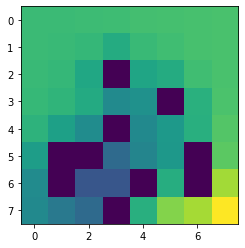

In [11]:
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=500000000, object_store_memory=5000000000)
MAP = map_8
map_size = 8
beta = 0.999
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed_v2(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed v2'] = end_time - start_time
print("time:", run_time['Sync distributed v2'])
print_results(v, pi, map_size, env, beta, 'dist_vi_v2')
ray.shutdown()

2020-07-05 18:30:45,178	INFO resource_spec.py:212 -- Starting Ray with 176.32 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Game Map:

SFFFFFFFFHFFFFHF
FFFFFFFFFFFFFHFF
FFFHFFFFHFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFF
FFHHFFFFFFFHFFFH
FFFFFFFFFFFFFFFF
FFFFFHFFFFFFHFFF
FFFFFHFFFFFFFFFH
FFFFFFFHFFFFFFFF
FFFFFFFFFFFFHFFF
FFFFFFHFFFFFFFFF
FFFFFFFFHFFFFFFF
FFFFFFFFFHFFFFHF
FFFFFFFFFFHFFFFF
FFFHFFFFFFFFFFFG
time: 5.690011024475098

State Value:

[[  457.18   459.72   463.33   470.96   495.85   504.93   499.92   469.88   283.22 -1000.     236.6    379.77   325.96    30.16 -1000.     131.65]
 [  454.     451.65   428.14   319.12   472.18   509.09   505.65   460.98   272.61   228.76   394.57   409.88   258.44 -1000.      66.26   294.93]
 [  448.68   430.85   281.62 -1000.     357.93   517.61   514.51   342.37 -1000.     265.33   440.63   440.02   401.89   258.59   339.76   352.78]
 [  443.84   431.02   385.04   316.26   497.41   544.26   542.09   374.62 -1000.     352.77   474.41   451.74   435.81   408.11   390.49   364.84]
 [  437.27   401.81   249.39   308.84   505.13   557.27   571.85   553.64   425.54   543.0

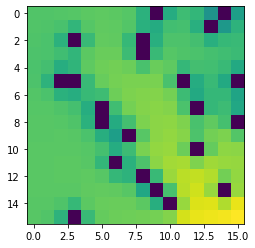

In [12]:
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=1000000000, object_store_memory=10000000000)
MAP = map_16
map_size = 16
beta = 0.999
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed_v2(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed v2'] = end_time - start_time
print("time:", run_time['Sync distributed v2'])
print_results(v, pi, map_size, env, beta, 'dist_vi_v2')
ray.shutdown()

2020-07-05 18:39:06,013	INFO resource_spec.py:212 -- Starting Ray with 176.32 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Game Map:

SFFHFFFFFFFFFFFFFFFFFFFFFFHFFFFF
FFHFHHFFHFFFFFFFFFFFFFFFFFHFFFFF
FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH
FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF
FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF
FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF
FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF
FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH
FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF
FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH
FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF
FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF
FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF
FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF
FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF
FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF
FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH
FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF
FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF
FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH
FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF
FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF
FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF
FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF

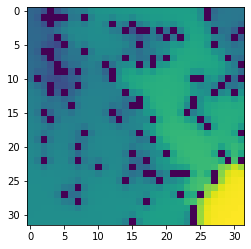

In [11]:
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=1000000000, object_store_memory=10000000000)
MAP = map_32
map_size = 32
beta = 0.999
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed_v2(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed v2'] = end_time - start_time
print("time:", run_time['Sync distributed v2'])
print_results(v, pi, map_size, env, beta, 'dist_vi_v2')
ray.shutdown()

## Comparison of different approachs

Run the following cell to compare the running time of different approaches. 

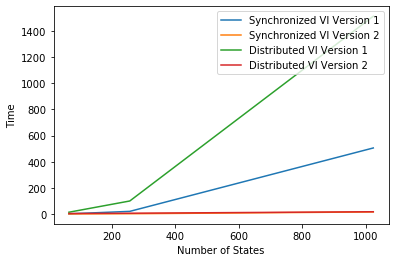

In [1]:
# from copy import deepcopy
# temp_dict = deepcopy(run_time)
# print("All:")
# for _ in range(len(temp_dict)):
#     min_v = float('inf')
#     for k, v in temp_dict.items():
#         if v is None:
#             continue
#         if v < min_v:
#             min_v = v
#             name = k
#     temp_dict[name] = float('inf')
#     print(name + ": " + str(min_v))
#     print()
import matplotlib.pyplot as plt

map_sizes = [8*8, 16*16, 32*32]
sync_v1 = [0.905534029006958, 19.822930812835693, 504.81746101379395]
sync_v2 = [0.3082435131072998, 1.6488120555877686, 15.390272855758667]
dist_v1 = [13.275201559066772, 99.23605060577393, 1512.3744518756866]
dist_v2 = [3.3376457691192627, 5.596921443939209, 17.000515699386597]

plt.plot(map_sizes, sync_v1)
plt.plot(map_sizes, sync_v2)
plt.plot(map_sizes, dist_v1)
plt.plot(map_sizes, dist_v2)
plt.xlabel('Number of States')
plt.ylabel('Time')
plt.legend(['Synchronized VI Version 1', 'Synchronized VI Version 2', 'Distributed VI Version 1', 'Distributed VI Version 2'], loc='upper right')
plt.show()

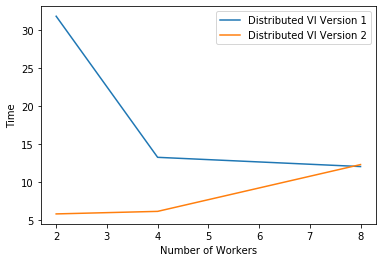

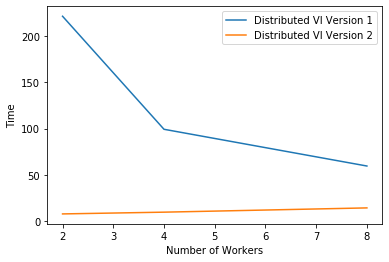

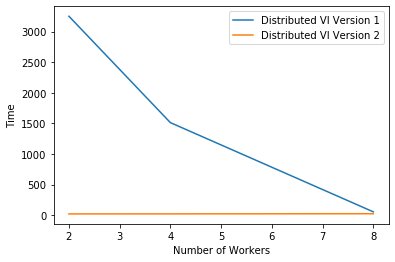

In [2]:
import matplotlib.pyplot as plt

dist_v1 = [31.86500906944275, 13.275201559066772, 12.058631896972656] #map_8
dist_v2 = [5.817586660385132, 6.152719497680664, 12.319599866867065]
workers = [2, 4, 8] 

plt.plot(workers, dist_v1)
plt.plot(workers, dist_v2)
plt.xlabel('Number of Workers')
plt.ylabel('Time')
plt.legend(['Distributed VI Version 1', 'Distributed VI Version 2'], loc='upper right')
plt.show()

dist_v1 = [221.6086447238922, 99.23605060577393,  59.4614896774292] #map_16
dist_v2 = [7.609274387359619, 9.507810354232788, 14.118886232376099]
workers = [2, 4, 8] 

plt.plot(workers, dist_v1)
plt.plot(workers, dist_v2)
plt.xlabel('Number of Workers')
plt.ylabel('Time')
plt.legend(['Distributed VI Version 1', 'Distributed VI Version 2'], loc='upper right')
plt.show()

dist_v1 = [3251.631986141205, 1512.3744518756866,  53.820802450180054] #map_32
dist_v2 = [19.813796520233154, 20.59328055381775, 23.074591875076294]
workers = [2, 4, 8] 

plt.plot(workers, dist_v1)
plt.plot(workers, dist_v2)
plt.xlabel('Number of Workers')
plt.ylabel('Time')
plt.legend(['Distributed VI Version 1', 'Distributed VI Version 2'], loc='upper right')
plt.show()

## Report
Write a report that includes the following:
- A plot that shows the running time of the above 4 approaches agianst the map sizes f 8, 16 and 32. 
- A plot that shows the running time of both distributed approaches agianst the number of the workers with 2, 4 and 8 workers.
- Breifly explain why the second distributed method is faster than the first one?
- Compere the best distributed method with the best non-distributed appraoch. Which one is better? Briefly explain why.

## Distributed Synchronous VI Competition
In this part, you should design and implement your own distributed synchronous VI method based on what you have learned in the previous parts. Your implementation has the following constraints:
- It must terminate and return a value function (and corresponding greedy policy) that satisfies the specified Bellman error threshold
- It must be iterative in the sense that it produces the same sequence of value functions as non-distributed synchronous value iteration

For this part, you should create a stand alone python file named `competition.py`. You can copy the needed functions from this notebook to your file. Your code should contain a main function called `fast_value_iteration` with the following exact signiture: 

`def fast_value_iteration(env, beta = 0.999, epsilon = 0.01, workers_num = 4)`

Here epsilon is the Bellman error threshold and worker_num is the maximum number of workers. This function should return policy and value vectors that satsify the Bellman error constraint. 

To test your code, you should use an exclusive compution node of DevCloud. You can use the `qsub -I -lselect=1` command to connect to a computation node and run your code on it. We may test your programs on problems as large as 100x100 FrozenLake environments. 

Some possible ideas to consider

- How should the number of workers be selected and how should states be partitioned across workers?
- Are there alternative protocols between the server and workers?
- Where are the communication bottlenecks in the system and how might they be improved? 

## Deliverables

Submit a zip file to Canvas that contains:
- completed version of this notebook
- the .pkl files generated by print_results function for your runs on map of size 8x8
- a python file for distributed VI competition
- your PDF report file